<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#목적" data-toc-modified-id="목적-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>목적</a></span></li><li><span><a href="#데이터-추출" data-toc-modified-id="데이터-추출-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 추출</a></span></li><li><span><a href="#EDA---1" data-toc-modified-id="EDA---1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA - 1</a></span></li><li><span><a href="#테스트셋-생성" data-toc-modified-id="테스트셋-생성-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>테스트셋 생성</a></span><ul class="toc-item"><li><span><a href="#계층적-샘플링" data-toc-modified-id="계층적-샘플링-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>계층적 샘플링</a></span></li></ul></li><li><span><a href="#EDA--2" data-toc-modified-id="EDA--2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA -2</a></span><ul class="toc-item"><li><span><a href="#logitude,-latitude" data-toc-modified-id="logitude,-latitude-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>logitude, latitude</a></span></li><li><span><a href="#상관계수" data-toc-modified-id="상관계수-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>상관계수</a></span></li><li><span><a href="#중위주택가격-vs-중위소득" data-toc-modified-id="중위주택가격-vs-중위소득-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>중위주택가격 vs 중위소득</a></span></li></ul></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>feature engineering</a></span></li><li><span><a href="#머신러닝-준비" data-toc-modified-id="머신러닝-준비-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>머신러닝 준비</a></span><ul class="toc-item"><li><span><a href="#결측치-처리" data-toc-modified-id="결측치-처리-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>결측치 처리</a></span></li><li><span><a href="#명목형-변수-처리" data-toc-modified-id="명목형-변수-처리-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>명목형 변수 처리</a></span></li><li><span><a href="#파이프라인-생성" data-toc-modified-id="파이프라인-생성-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>파이프라인 생성</a></span></li></ul></li><li><span><a href="#모델링(선형회귀,-결정트리)" data-toc-modified-id="모델링(선형회귀,-결정트리)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델링(선형회귀, 결정트리)</a></span></li><li><span><a href="#교차검증" data-toc-modified-id="교차검증-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>교차검증</a></span></li><li><span><a href="#모델-튜닝" data-toc-modified-id="모델-튜닝-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>모델 튜닝</a></span><ul class="toc-item"><li><span><a href="#그리드-탐색" data-toc-modified-id="그리드-탐색-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>그리드 탐색</a></span></li><li><span><a href="#오차분석" data-toc-modified-id="오차분석-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>오차분석</a></span></li></ul></li><li><span><a href="#모델-결정-및-outsample-테스트" data-toc-modified-id="모델-결정-및-outsample-테스트-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>모델 결정 및 outsample 테스트</a></span></li></ul></div>

In [1]:
# libraries

# 데이터 추출
import os
import tarfile
from six.moves import urllib

# 데이터 로드
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams['figure.figsize'] = [12, 5]  # 플롯 기본 크기 설정

# 테스트셋 생성
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV

# 결측치 처리
from sklearn.impute import SimpleImputer

# 머신러닝 준비
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.base import BaseEstimator, TransformerMixin  # 변환기 정의

# 파이프라인 생성
from sklearn.pipeline import Pipeline, FeatureUnion

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## 목적
* 중간 주택 가격(median housing price) 예측
* 평가 지표: RMSE
* references: https://github.com/rickiepark/handson-ml

## 데이터 추출

In [2]:
# root, url 설정
download_root = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'  # 다운로드 페이지
housing_path = os.path.join('data')  # 저장경로
housing_url = download_root + 'datasets/housing/housing.tgz'


# 데이터 다운로드
def fetch_housing_data(housing_url=housing_url, housing_path=housing_path):
    if not os.path.isdir(housing_path):
        os.mkdir(housing_path)
        
    tgz_path = os.path.join(housing_path, ' housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)  # tgz_path에 저장
    housing_tgz = tarfile.open(tgz_path)  # tgz 파일 열기
    housing_tgz.extractall(path=housing_path)  # tgz 압축을 풀고, housing path에 저장
    housing_tgz.close()
    return f'downloaded data at {housing_path}/, from {housing_url}'

In [3]:
fetch_housing_data()

'downloaded data at data/, from https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'

## EDA - 1

In [4]:
csv_path = os.path.join(housing_path, 'housing.csv')
housing_df = pd.read_csv(csv_path)

print('='*40 + 'head' + '='* 40)
display(housing_df.head())
print('='*40 + 'info' + '='* 40)
display(housing_df.info())
print(f'shape: {housing_df.shape}')
print('='*40 + 'desc' + '='* 40)
display(housing_df.describe(include='all'))

========================================head========================================


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


========================================info========================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

shape: (20640, 10)
========================================desc========================================


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


* Observations
    * 데이터는 20640행 10열
    * `total_bedrooms` 결측치 207건
    * `ocean_proximity`를 제외한 모든 변수는 수치형

In [5]:
# ocean_proximity 확인
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

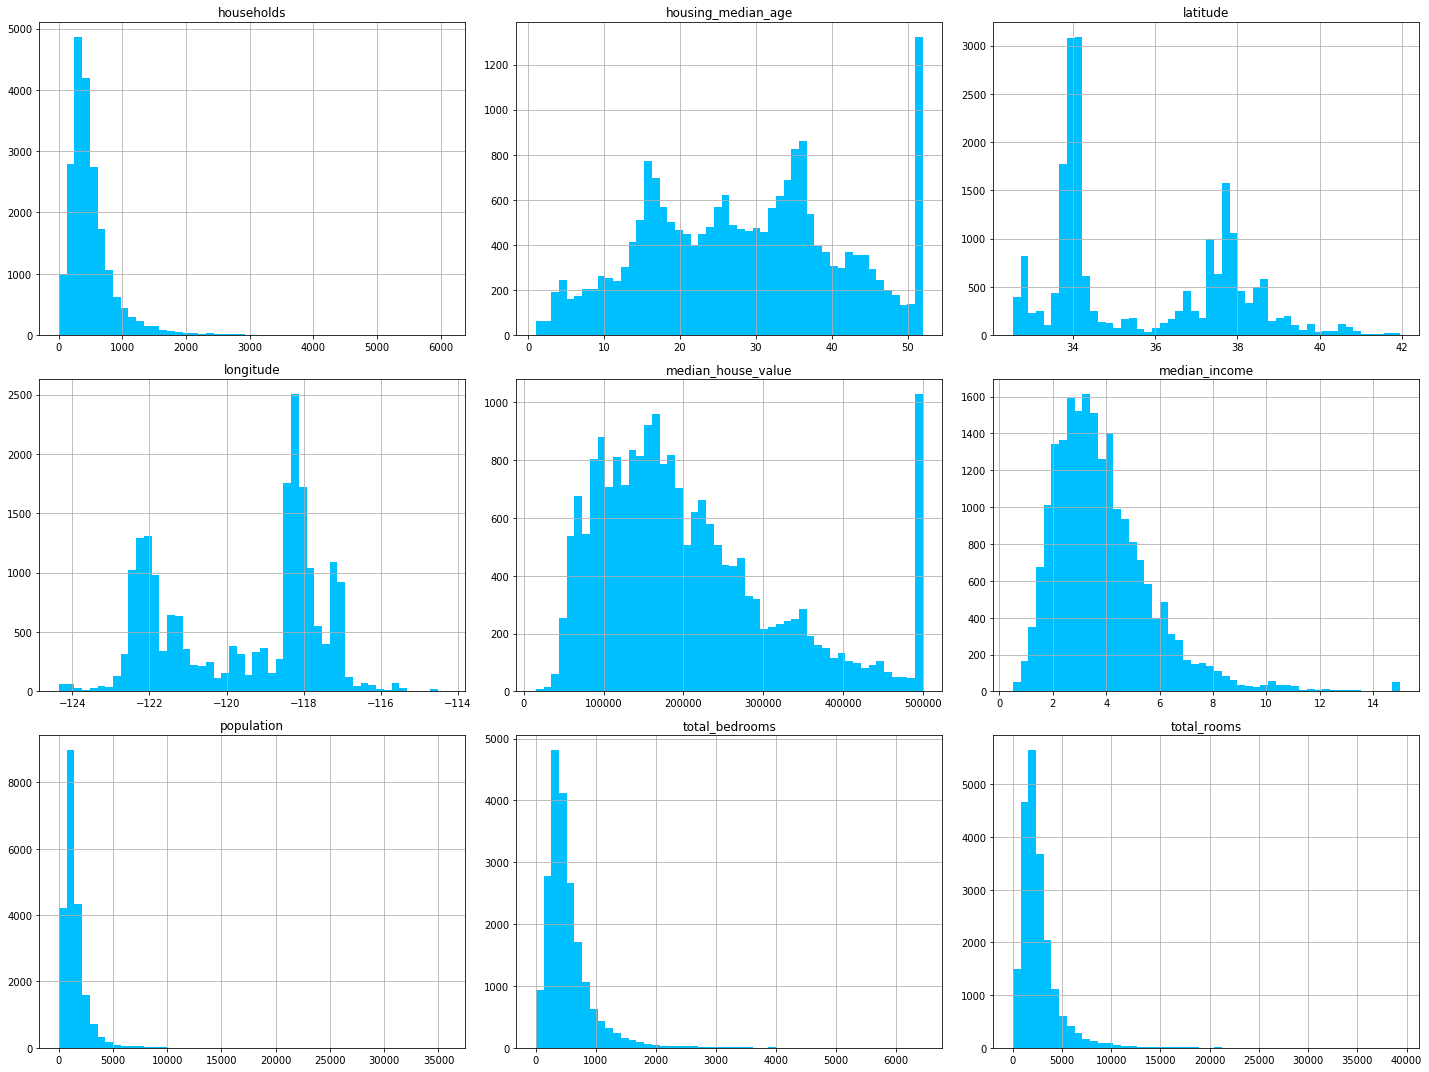

In [6]:
# FAST EDA
housing_df.hist(bins=50, figsize=[20, 15], color='deepskyblue')
plt.tight_layout()
plt.show()

* Observations
    * `중위주택연령(housing_median_age)`, `중위주택가격(housing_median_value)` 히스토그램 우측 값이 가장 높다.
        * 중위주택연령과 중위주택가격의 상한선(50년, 500,000$)을 설정하고, 상한선 이상의 데이터를 모두 상한값으로 처리한것같다.
        * 예측모델이 결과에 상한값이 적용될 수 있다. 
        * 상한값 이상의 결과를 출력하는 예측모델을 만들고 싶다면 
            * 상한값 이상 구역의 데이터를 구해야한다.
            * test data set에서 상한값 이상의 데이터를 제거한다. 만약 상한값 이상의 데이터가 있다면 평가 결과가 나쁠것이다.
    * `중위소득(median_income)`은 스케일링 처리가 된 것으로 보임(0-15)
    * 특성의 범위가 서로 다르다.
        * 스케일링이 필요하다.
    * `household`, `median_income`, `population`, `total_bedrooms`, `total_rooms` 히스토그램은 **양의 왜도**를 보인다.

## 테스트셋 생성
* 데이터 스누핑(data snooping): 테스트셋을 미리 분리하지 않고 데이터를 탐색한 후 테스트 셋의 특성을 예측모델에 적용해 과적합이 발생하는 현상. 데이터를 탐색하기 전에 미리 테스트셋을 분리하는 것이 좋다. 답지를 보면서 문제 푸는것과 비슷하다.

In [7]:
# 1. 트레인 데이터와 테스트 데이터를 8:2로 분류한다.
def split_train_test(data, test_ratio, seed):
    np.random.seed(seed)  # set random seed
    
    indices = np.random.permutation(len(data))  # 인덱스를 섞는다
    test_size = int(len(data) * test_ratio)
    test_indices = suffled_indices[:test_size]
    train_indices = suffled_indices[test_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
# 2. 해시값으로 테스트셋 생성
def test_set_check(identifier, ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < ratio * 2**32


def split_train_test_by_id(data, ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id_df = housing_df.reset_index()
train_df, test_df = split_train_test_by_id(data=housing_with_id_df, ratio=0.2, id_column='index')

# 위도, 경도와 id를 조합해 고유 식별자 생성
housing_with_id_df['id'] = housing_df['longitude'] * 1000 + housing_df['latitude']
train_df, test_df = split_train_test_by_id(data=housing_with_id_df, ratio=0.2, id_column='id')

In [9]:
# 3. sklearn 모듈 사용
train_df, test_df = train_test_split(housing_df, test_size=0.5, random_state=42)

### 계층적 샘플링
    * 중위소득은 중위주택가격을 예측하는데 중요한 변수다.
    * 테스트셋이 모집단의 중위소득을 반영할 수 있도록 계층적 샘플링을 진행한다.

In [10]:
housing_df['income_cat'] = np.ceil(housing_df['median_income']/1.5)
housing_df['income_cat'].where(cond=housing_df['income_cat']<5.0, other=5, inplace=True)

In [11]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)  # 5번 뽑아보자

In [12]:
# y 비율에 따라 계층적 샘플링 진행
# The target variable for supervised learning problems. Stratification is done based on the y labels.
for train_idx, test_idx in split.split(X=housing_df, y=housing_df['income_cat']):
    train_strat_df = housing_df.loc[train_idx]
    test_strat_df = housing_df.loc[test_idx]

In [13]:
# 랜덤샘플링
train_df, test_df = train_test_split(housing_df, test_size=.2, random_state=42)

In [14]:
# income_cat 비율확인
tot_income_cat_ratio = housing_df['income_cat'].value_counts()/len(housing_df)
test_income_cat_ratio = test_df['income_cat'].value_counts()/len(test_df)
test_strat_income_cat_ratio = test_strat_df['income_cat'].value_counts()/len(test_strat_df)

In [15]:
res_ratio_df = pd.concat([tot_income_cat_ratio, test_income_cat_ratio, test_strat_income_cat_ratio],axis=1)
res_ratio_df.columns=['total', 'random_sample', 'stratified_sample']
res_ratio_df['tot-random'] = res_ratio_df['total'] - res_ratio_df['random_sample']
res_ratio_df['tot-stratified'] = res_ratio_df['total'] - res_ratio_df['stratified_sample']
display(res_ratio_df)

,total,random_sample,stratified_sample,tot-random,tot-stratified
3.0,0.350581,0.358527,0.350533,-0.007946,0.000048
2.0,0.318847,0.324370,0.318798,-0.005523,0.000048
4.0,0.176308,0.167393,0.176357,0.008915,-0.000048
5.0,0.114438,0.109496,0.114583,0.004942,-0.000145
1.0,0.039826,0.040213,0.039729,-0.000388,0.000097


In [16]:
# income_cat을 삭제한다.
for set_ in (train_strat_df, test_strat_df):
    set_.drop(['income_cat'], axis=1, inplace=True)

## EDA -2

In [17]:
# 복사본 만들기
housing = train_strat_df.copy()

### logitude, latitude

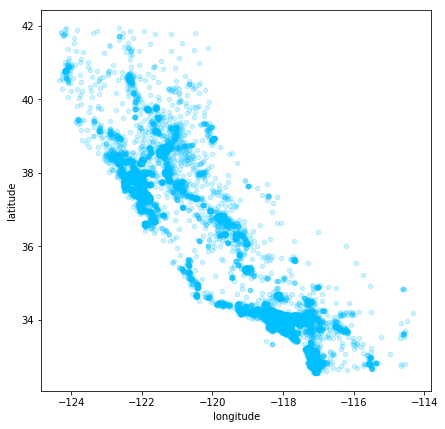

In [18]:
# 지역에 따른 구역 밀도
housing.plot(x='longitude', y='latitude', kind='scatter', figsize=[7,7], alpha=.2, color='deepskyblue')
plt.show()

* observations
    * 샌프란시스코 베이에어리어, 샌디에고, 프레즈노, 새크라멘토 등에 밀집했다.

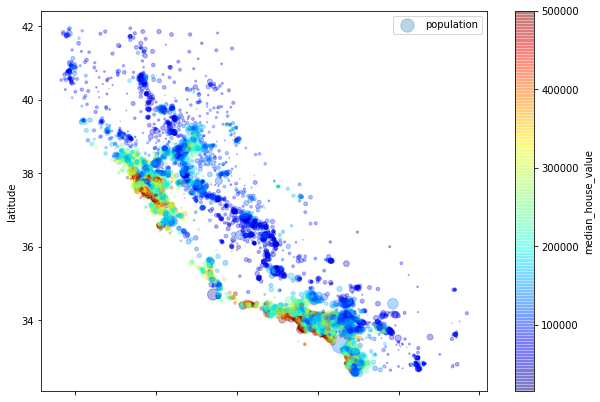

In [19]:
# 지역에 따른 주택중위가격
# s: size, c:color
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.3,
             s=housing['population']/100, label='population', figsize=(10, 7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

* Observations
    * 인구밀도가 높고 해안에 근접한 지역의 중위주택가격이 높다.
    * 북부 해안(위도 35도 위쪽)은 샌프란시스코 베이 에어리아를 제외하면 중위주택가격이 낮은편이다.

### 상관계수

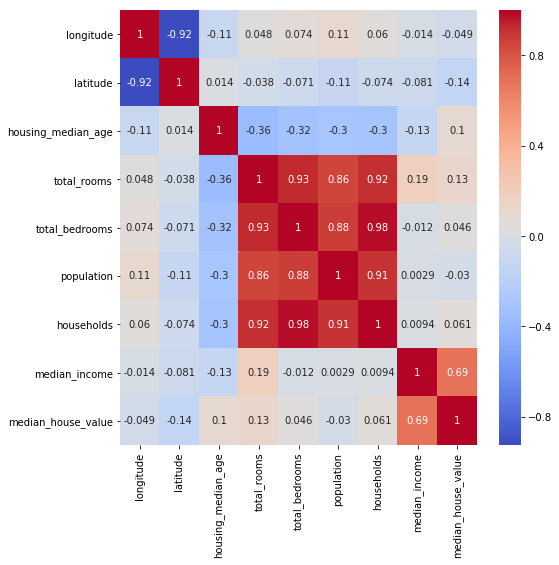

In [20]:
corr_mat = housing.corr()
plt.figure(figsize=[8, 8])
sb.heatmap(corr_mat, cmap='coolwarm', annot=True)
plt.show()

* Observations
    * 중위주택가격은 중위소득과 양의 상관관계가 있음(0.69)
    * 중위주택가격은 위도와 약한 음의 상관관계가 있음(0.14)
        * 북쪽으로 올라갈수록 가격이 약간 낮아짐

### 중위주택가격 vs 중위소득

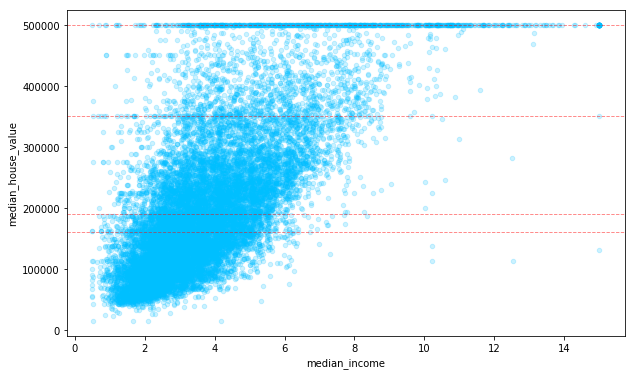

In [21]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.2, figsize=[10,6], color='deepskyblue')
for y in [500000, 350000, 190000, 160000]:
    plt.axhline(y=y, ls='--', lw=.9, color='red', alpha=.5)
plt.show()

* Observations
    * 강한 양의 상관관계가 보인다.
    * median_house_value 500,000, 450,000, 350,000, 200,000 부근 에서 수평선이 발견된다.
        * 데이터 수집시 기준값을 정해놓고, 조건에 따라 원래값을 변환한 것으로 보인다.
        * 해당 구역을 제거하는것이 좋다.

## feature engineering

In [22]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']  # 가구당 평균 방 수
housing['bed_per_room'] = housing['total_bedrooms'] / housing['total_rooms']  # 방 하나당 침대 수
housing['population_per_household'] = housing['population'] / housing['households']  # 가구당 평균 인원수

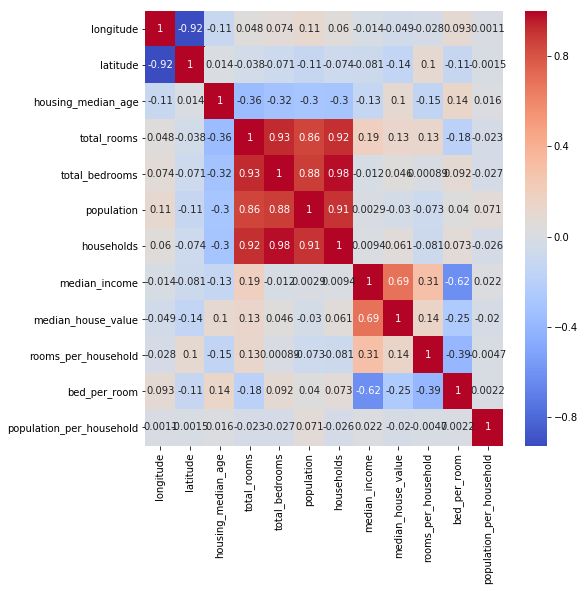

In [23]:
# 상관계수 확인
corr_mat = housing.corr()
plt.figure(figsize=[8, 8])
sb.heatmap(corr_mat, cmap='coolwarm', annot=True)
plt.show()

* Observations
    * 가구당 평균 방수는 중위주택평균과 약한 양의 상관관계가 있다.(0.15)
    * 방당 평균 침대 수는 중위주택평균과 약한 음의 상관관계가 있다.(-0.26)

## 머신러닝 준비

In [24]:
# 독립변수, 종속변수 분리
housing_x = train_strat_df.drop('median_house_value', axis=1)
housing_y = train_strat_df['median_house_value'].copy()

### 결측치 처리
1. 결측치 제거
2. 전체특성 제거
3. 중위값으로 대체
    * 테스트셋에서 누락될 겅우 트레인셋의 중위값을 사용해야함

In [25]:
imputer = SimpleImputer(strategy='median')  # sklearn
housing_num = housing_x.drop('ocean_proximity', axis=1)  # 수치형 변수만 추출
# 결측치 비율확인
print('='*40 + 'na ratio: before inputation' + '='*40)
display(housing_num.isna().mean())
imputer.fit(housing_num)
print(f'각열의 중위값: {imputer.statistics_}')
x = imputer.transform(housing_num)  # numpy
print('='*40 + 'na ratio: after inputation' + '='*40)
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=list(housing.index.values))  # to df
display(housing_tr.isna().mean())

========================================na ratio: before inputation========================================


longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.009872
population            0.000000
households            0.000000
median_income         0.000000
dtype: float64

각열의 중위값: [-118.49      34.25      29.      2134.       437.      1171.
  411.         3.54035]
========================================na ratio: after inputation========================================


longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
dtype: float64

### 명목형 변수 처리
* 라벨링의 문제점
    * 머신러닝 알고리즘이 숫자에 따라 거리를 산출한다.
        * ex) 0: a, 1:b, 5:c 로 라벨링했을 때 a-b 는 a-c 보다 멀다
    * onehot encoding 사용
* 카테고리가 많을 때 onehot encoding 문제점?

In [26]:
# 라벨링
housing_oc = housing['ocean_proximity']
housing_oc_encoded, housing_oc_cat = housing_oc.factorize()  # 라벨링
housing_oc_cat

# onehot encoding
encoder = OneHotEncoder(categories='auto')
housing_oc_onehot = encoder.fit_transform(housing_oc_encoded.reshape(-1, 1))

In [27]:
# 라벨링 안해도 가능
encoder = OneHotEncoder(categories='auto')
housing_oc_onehot = encoder.fit_transform(housing_oc.values.reshape(-1, 1))

* 변환기 생성
    * `-Mixin`은 fit_transform() 메서드를 포함. 상속하면 fit_transform() 메서드를 사용할 수 있다.
    * `BaseEstimator`는 get_params(), set_parmas()를 포함
    * 간단하게 파라메터를 추가/제거한다. 변수에대한 확신이 없을 때 준비단계를 자동화해 시간을 줄인다.
        * `add_bedrooms_per_room` 변수를 추가/제거할 수 있다

In [28]:
rooms_ix, bedrooms_ix, populations_ix, household_ix = 3, 4, 5, 6

class AttributeAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    
    def fit(self, x, y=None):
        return self
    
    
    def transform(self, x, y=None):
        rooms_per_household = x[:, rooms_ix] / x[:, household_ix]
        population_per_household = x[:, rooms_ix] / x[:, populations_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = x[:, bedrooms_ix] / x[:, rooms_ix]
            return np.c_[x, rooms_per_household, population_per_household, bedrooms_per_room]  # column bind
        else:
            return np.c_[x, rooms_per_household, population_per_household]

In [29]:
attr_adder = AttributeAdder(add_bedrooms_per_room=True)
housing_extar_attr = attr_adder.transform(housing.values)

### 파이프라인 생성
* 스케일링
    * 트리기반 알고리즘을 제외하면 스케일링을 해줘야한다.
    * 표준화: 평균 0, 분산 1로 맞춘다. 범위를 규정하지 않아 문제가 발생할 수 있다. 이상치의 영향을 덜받는다.
    * 정규화: 모두 0-1의 범위로 맞춘다.
        * ex) 실수로 중위소득을 100으로 입력했을 때 0-15 사이의 값은 모두 0-0.15 사이로 정규환된다.
        * 표준화를 하면 크게 영향을 받지 않는다.
* 파이프라인
    * (이름, 추정기) 로 입력
    * 마지막단계에서는 변환기/추정기(머신러닝) 사용 가능. 나머지는 모두 변환기
    * 파이프라인 fit() 메서드: 모든 변환기의 fit_transform 호출, 마지막 단계에서는 fit 메서드만 호출

In [30]:
housing_num_attr_names = list(housing_num.columns)
housing_cat_attr_names = ['ocean_proximity']


# dataframe 중 변수의 이름을 받아 numpy 배열로 출력하는 변환기
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    
    def fit(self, x, y=None):
        return self
    
    
    def transform(self, x):
        return x[self.attribute_names].values
    

# 수치형 변수 파이프라인
num_pipeline = Pipeline([
    ('selecter', DataFrameSelector(housing_num_attr_names)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', AttributeAdder(add_bedrooms_per_room=True)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(housing_cat_attr_names)),
    ('encoder', OneHotEncoder(sparse=False))
])


# 두 파이프라인 병렬로 합치기
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipelne', cat_pipeline)
])

# 파이프라인 실행
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.71152955, -0.87328421,  1.69364505, ...,  0.        ,
         0.        ,  1.        ],
       [-1.15617031,  0.78401285,  1.06080258, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56171406, -0.62515782,  0.26974949, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14722451,  0.3252131 , -1.54967262, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29704001,  0.94318828, -1.15414608, ...,  0.        ,
         0.        ,  0.        ],
       [-1.6955061 ,  1.30835543,  1.69364505, ...,  0.        ,
         0.        ,  0.        ]])

## 모델링(선형회귀, 결정트리)

In [31]:
# 선형회귀
lm = LinearRegression()
lm.fit(housing_prepared, housing_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
y_pred = lm.predict(housing_prepared)
mse = mean_squared_error(housing_y, y_pred)
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')

rmse: 67149.84762327216


* Observations
    * 과소적합
        * 강력한 모델을 선택한다.
        * 변수를 다시 선택한ㄷ다.

In [33]:
# 결정트리
tree_m = DecisionTreeRegressor()
tree_m.fit(housing_prepared, housing_y)
y_pred_tree = tree_m.predict(housing_prepared)
mse = mean_squared_error(housing_y, y_pred_tree)
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')

rmse: 0.0


* 과적합 발생? =>교차검증해본다.

## 교차검증
* 10번반복
    * 트레인셋을 10개로 나눈다.
    * 9개로 학습한다.
    * 나머지 1개로 검증한다.
* 사이킷런 교차검증은 scoring 값이 큰 효용함수를 기대하기 때문에 음수 오차제곱합을 평가지표로 설정한다.

In [34]:
m_tree, m_lin, m_rf = DecisionTreeRegressor(), LinearRegression(), RandomForestRegressor(n_estimators=10)
cv_scores_tree = cross_val_score(estimator=m_tree, X=housing_prepared, y=housing_y, scoring='neg_mean_squared_error', cv=10)
cv_scores_lin = cross_val_score(estimator=m_lin, X=housing_prepared, y=housing_y, scoring='neg_mean_squared_error', cv=10)
cv_scores_rf = cross_val_score(estimator=m_rf, X=housing_prepared, y=housing_y, scoring='neg_mean_squared_error', cv=10)

cv_scores_tree = np.sqrt(-cv_scores_tree)
cv_scores_lin = np.sqrt(-cv_scores_lin)
cv_scores_rf = np.sqrt(-cv_scores_rf)

In [35]:
# insample rmse
m_tree.fit(housing_prepared, housing_y)
y_pred_tree = tree_m.predict(housing_prepared)
insample_rmse_tree = np.sqrt(mean_squared_error(housing_y, y_pred_tree))

m_lin.fit(housing_prepared, housing_y)
y_pred_lin = m_lin.predict(housing_prepared)
insample_rmse_lin = np.sqrt(mean_squared_error(housing_y, y_pred_lin))

m_rf.fit(housing_prepared, housing_y)
y_pred_rf = m_rf.predict(housing_prepared)
insample_rmse_rf = np.sqrt(mean_squared_error(housing_y, y_pred_rf))

In [36]:
print(f'''
============tree cv score===========

insample_rmse:{insample_rmse_tree}
mean: {cv_scores_tree.mean()}
std: {cv_scores_tree.std()}

============lm cv score===========

insample_rmse:{insample_rmse_lin}
mean: {cv_scores_lin.mean()}
std: {cv_scores_lin.std()}

============rf cv score=============

insample_rmse:{insample_rmse_rf}
mean: {cv_scores_rf.mean()}
std: {cv_scores_rf.std()}

''')



============tree cv score===========

insample_rmse:0.0
mean: 70120.28106098757
std: 2012.6605730504832

============lm cv score===========

insample_rmse:67149.84762327216
mean: 67901.20867839243
std: 2600.669841098487

============rf cv score=============

insample_rmse:21879.880703719755
mean: 51593.38073729762
std: 1310.8056606763143




* tree 는 insample 에서 과적합 발생
* randomforest 가 제일 좋으나 insample rmse가 훨씬 작음. 과적합 문제가 남아있음.
    * 과적합문제 해결
        * 모델을 간단하게 만든다
        * 데이터를 더 모은다
* 가능성있는 모델 5-6가지를 고른다

## 모델 튜닝
* 하나의 모델에 대한 최적의 파라메터를 찾는다.

### 그리드 탐색

In [37]:
# 첫번째 딕셔너리 의 3x4 개 조합 시도, 두번째 딕셔너리 2x3 조합 시도 총 12+6 = 18 개 조합 탐색
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

rf_m = RandomForestRegressor(n_estimators=10)

grid_search = GridSearchCV(estimator=rf_m, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
# 최적 파라메터
print(grid_search.best_params_)

{'max_features': 8, 'n_estimators': 30}


In [39]:
# 최적 추정기
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [40]:
# 평가점수 확인
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

62961.87779423111 {'max_features': 2, 'n_estimators': 3}
55063.898174619695 {'max_features': 2, 'n_estimators': 10}
52806.19859729019 {'max_features': 2, 'n_estimators': 30}
60053.67074698632 {'max_features': 4, 'n_estimators': 3}
52506.72996680016 {'max_features': 4, 'n_estimators': 10}
50360.624058324116 {'max_features': 4, 'n_estimators': 30}
58439.0640527696 {'max_features': 6, 'n_estimators': 3}
51791.022627070335 {'max_features': 6, 'n_estimators': 10}
49719.68056351997 {'max_features': 6, 'n_estimators': 30}
57813.28721117323 {'max_features': 8, 'n_estimators': 3}
51318.51783323987 {'max_features': 8, 'n_estimators': 10}
49280.18737728592 {'max_features': 8, 'n_estimators': 30}
62420.81633688795 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54148.15453737399 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59884.34775819571 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52681.39403422409 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

### 오차분석

In [64]:
# 변수 중요도
feature_importances = grid_search.best_estimator_.feature_importances_
extra_att = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_one_hot_att = encoder.categories_
attrs = housing_num_attr_names + extra_att +  cat_one_hot_att[0].tolist()
sorted(zip(feature_importances, attrs), reverse=True)

[(0.4033330557418816, 'median_income'),
 (0.13517442901232016, 'INLAND'),
 (0.11698251888839412, 'population_per_household'),
 (0.07778685461112116, 'longitude'),
 (0.06538988638470469, 'latitude'),
 (0.05021076763450358, 'bedrooms_per_room'),
 (0.039927743685279765, 'housing_median_age'),
 (0.039782453592122076, 'rooms_per_household'),
 (0.015188697178302873, 'population'),
 (0.014472150656724695, 'households'),
 (0.014229192420738794, 'total_bedrooms'),
 (0.01397190121725537, 'total_rooms'),
 (0.007929882126602629, '<1H OCEAN'),
 (0.0031379453838674774, 'NEAR OCEAN'),
 (0.002320958536366324, 'NEAR BAY'),
 (0.00016156292981465634, 'ISLAND')]

* Observations
    * ocean_proximity 중 `INLAND` 변수를 제외하고 나머지는 중요도가 떨어진다.

## 모델 결정 및 outsample 테스트

In [66]:
model_final = grid_search.best_estimator_  # 모델 결정

x_test = test_strat_df.drop('median_house_value', axis=1)
y_test = test_strat_df['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)
y_pred_final = model_final.predict(x_test_prepared)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f'final rmse: {rmse_final}')

final rmse: 48865.36260971018
